Install dependencies

# Signal Language Recognition

# 1. Introduction

In this project I implemented a CNN model to recognize of 24 static hand signs of the American Sign Language alphabet. J and Z are excluded as they contain motion.
The dataset I used for training & validating is [Sign Language MNIST](https://www.kaggle.com/datasets/datamunge/sign-language-mnist).
The proposed model reaches the accuracy of 97% on the validation dataset after being trained for 9.5 minutes.

# 2. Methodology
## 2.1. Model
I implemented CNN model with those layers:
- Input layer: A grayscale image (28x28) of a hand sign (only hand)
- Convolutional layer 1
- Pool layer 1
- Convolutional layer 2
- Pool layer 2
- Convolutional layer 3
- Pool layer 3
- Flatten layer
- Fully connected layer 1
- Fully connected layer 2
- Fully connected layer 3
- Output layer: output the classification result

## 2.2. Training process
A dataset of 27.4k grayscale images were used to train the model (approximate 1.1k images for each sign).
The dataset was augmented by cropping & changing contracts of the original images.
The training process is terminated if it reaches 50 epochs or the traning doesn't reduce loss efficiently anymore.
The calculated weights were store into `checkpoint.pth` to use later

# 3. Results
The model was trained in 9m28s (50 epochs)
Accuracy reaches 97.77%

# 4. Future works
1. Try other models & hyperparameters
2. Improve model to regcognize signs in motion (videos)

In [117]:
!source .venv/bin/activate
!pip install -r requirements.txt


[notice] A new release of pip is available: 24.2 -> 24.3
[notice] To update, run: pip install --upgrade pip


In [118]:
# Download the dataset
import os
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()

dataset_path = 'datasets/datamunge/sign-language-mnist'
dataset_files = [x for x in os.listdir(dataset_path) if x != '.DS_Store']
if not dataset_files:
    api.dataset_download_files("datamunge/sign-language-mnist", path=dataset_path, unzip=True)
    print("Dataset has been downloaded into ", dataset_path)
else:
    print("Dataset is already downloaded into ", dataset_path)

Dataset is already downloaded into  datasets/datamunge/sign-language-mnist


In [52]:
# Visualize the dataset
import pandas as pd
import numpy as np

trainset_csv_path = f'{dataset_path}/sign_mnist_train.csv'
testset_csv_path = f'{dataset_path}/sign_mnist_test.csv'

train_csv = pd.read_csv(trainset_csv_path)
test_csv = pd.read_csv(testset_csv_path)

train_data = np.array(train_csv)
test_data = np.array(test_csv)

numeric_labels = list(range(26))
numeric_to_alpha_label_map = {numeric_label: chr(65 + numeric_label) for numeric_label in numeric_labels}

ab_classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y' ]
num_classes = [ord(c) - 65 for c in ab_classes]

print(f"train shape: {train_csv.shape}")
print(f"test shape: {test_csv.shape}")

train shape: (27455, 785)
test shape: (7172, 785)


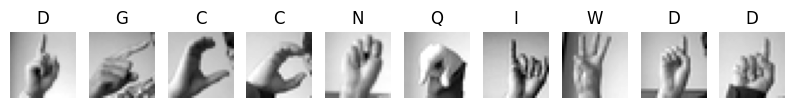

In [53]:
import math
import matplotlib.pyplot as plot


img_size = None



# plot the first 10 images
number_imags_to_plot = 10
img_fig_size = 10
fig, axes = plot.subplots(1, number_imags_to_plot, figsize=(img_fig_size, img_fig_size))
for i, ax in enumerate(axes):
    numeric_label, *img_1d = train_data[i]
    img_1d = np.array(img_1d)
    img_pixel_count = img_1d.shape[0]
    img_size = int(math.sqrt(img_pixel_count))
    ax.imshow(img_1d.reshape((img_size, img_size)), cmap='gray')
    alpha_label = numeric_to_alpha_label_map[numeric_label]
    ax.set_title(alpha_label)
    ax.axis('off')


Text(0.5, 1.0, 'Label')

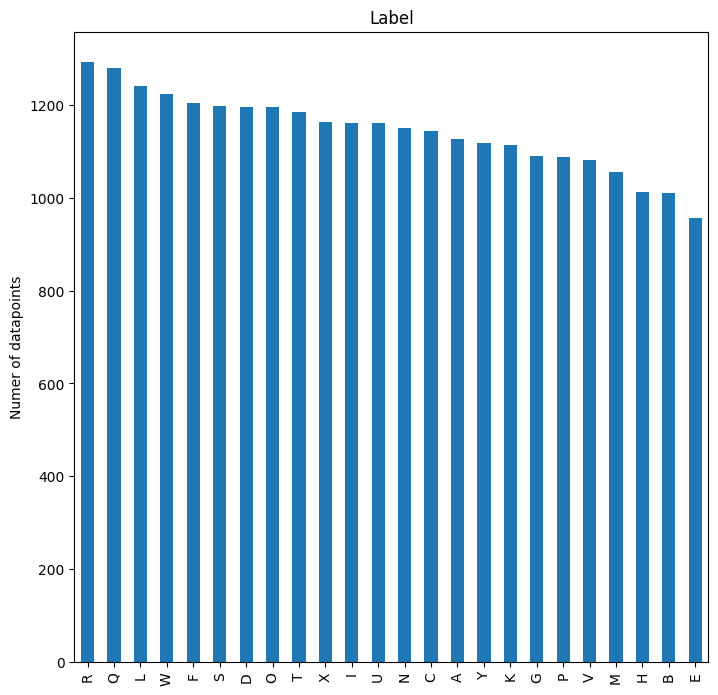

In [54]:
# Show distribution of train data
distribution = train_csv['label'].value_counts(sort=True)
distribution.index = [ numeric_to_alpha_label_map[x] for x in distribution.index]
fig = plot.figure(figsize=(18,18))
ax1 = fig.add_subplot(221)
distribution.plot(kind='bar', ax=ax1)
ax1.set_ylabel('Numer of datapoints')
ax1.set_title('Label')

In [55]:
# Model implementation
import torch.nn as nn
import torch.nn.functional as F

class SlrModel(nn.Module):
    def __init__(self):
        super(SlrModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=self.conv1.out_channels, out_channels=6, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=self.fc1.out_features, out_features=48)
        self.fc3 = nn.Linear(in_features=self.fc2.out_features, out_features=24)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, self.fc1.in_features)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [83]:
# Dataset implementation
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import torch

class SlrDataset(Dataset):
    def __init__(self, data_csv):
        data_row = np.array(data_csv)
        labels = []
        image_datas = []
        for row in data_row:
            l, *s = row
            labels.append(num_classes.index(l))
            image_datas.append(s)
        self._image_datas = np.array(image_datas, dtype=np.uint8).reshape((-1, img_size, img_size, 1))
        self._labels = np.array(labels, dtype=np.uint8).reshape((-1, 1))
    
    def __len__(self):
        return len(self._labels)

    def __getitem__(self, idx):
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop(28, scale=(0.8, 1.2)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229]), 
        ])
        return {
            'image': transform(self._image_datas[idx]).float(),
            'label': torch.from_numpy(self._labels[idx]).float()
        }


In [93]:
# Train the model
import torch.optim as optim
from torch.autograd import Variable

def train_epoch(model, optimizer, trainloader, verbose=False):
    criterion = nn.CrossEntropyLoss()
    sum_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs = Variable(data['image'].float())
        labels = Variable(data['label'].long())
        optimizer.zero_grad()

        # forward propagation
        outputs = model(inputs)

        # backward propagation
        loss = criterion(outputs, labels[:, 0])
        loss.backward()

        # optimize
        optimizer.step()

        sum_loss += loss.item()
        
        if verbose and i % 100 == 0:
            current_avg_loss = sum_loss / (i + 1)
            print(f'i={i} avg_loss={current_avg_loss}')
   
    avg_loss = sum_loss / len(trainloader)
    return avg_loss     


In [58]:
# Evaluate the model
def evaluate(model, testloader):
    def cal_score_of_1_prediction(actual_prediction, expected_prediction):
        expected = expected_prediction[0][0]
        actual = np.argmax(actual_prediction[0].detach().numpy())
        return 1 if actual == expected else 0
    
    score_sum = 0
    for batch in testloader:
        actual_prediction = model(batch['image'])
        score_sum += cal_score_of_1_prediction(actual_prediction, batch['label'] )
    avg_score = score_sum / len(testloader)
    return avg_score

Augmented train images


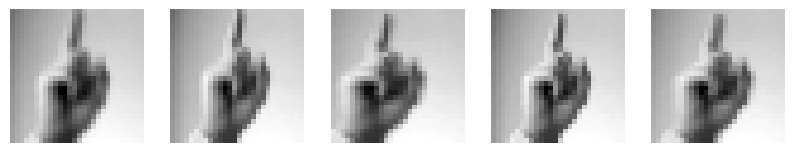

In [91]:
# Prepare train data and test data
batch_size = 32
trainset = SlrDataset(train_csv)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = SlrDataset(test_csv)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

print('Augmented train images')
# Show how the original train image are cropped randomly eo enrich the train dataset
image_idx = 0
number_imags_to_plot = 5
img_fig_size = 10
fig, axes = plot.subplots(1, number_imags_to_plot, figsize=(img_fig_size, img_fig_size))
for i, ax in enumerate(axes):
    numeric_label = trainset[image_idx]['label']
    img_2d = trainset[image_idx]['image'].numpy()[0]
    img_pixel_count = img_2d.shape[0]
    ax.imshow(img_2d, cmap='gray')
    ax.axis('off')

In [109]:
# main
import sys

checkpoint_path = "checkpoint.pth"
model = SlrModel()

# uncomment the following line to load the pretrain weights
# model.load_state_dict(torch.load(checkpoint_path, weights_only=True))

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


min_epochs = 3 # train in at least this number of epochs
max_epochs = 50 # train in at most this number of epochs
bad_loss_delta_times = 5
min_loss_delta_threshold = 0.0002 # if the train loss if an epoch is less than this value for {bad_loss_delta_times} times sequentially, we stop training

prev_loss = sys.float_info.max
remaining_bad_loss_delta_tolerances = bad_loss_delta_times

train_losses = []
val_accuracies = []
min_loss_accuracy = {"epoch": 0, "accuracy": 0}

min_loss = prev_loss
epoch_count = 0
for i in range(max_epochs):
    epoch_count += 1
    curerent_loss = train_epoch(model, optimizer, trainloader)
    curerent_accuracy = evaluate(model, testloader)
    train_losses.append(curerent_loss)
    val_accuracies.append(curerent_accuracy)

    current_loss_delta = prev_loss - curerent_loss
    if (epoch_count > min_epochs and current_loss_delta < min_loss_delta_threshold):
        remaining_bad_loss_delta_tolerances -= 1
    else:
        remaining_bad_loss_delta_tolerances = bad_loss_delta_times
    print(f'epoch={epoch_count}, loss={curerent_loss}, loss_delta={current_loss_delta}')
    if (remaining_bad_loss_delta_tolerances <= 0):
        break
    scheduler.step()
    prev_loss = curerent_loss
    if curerent_loss < min_loss:
        min_loss = curerent_loss
        min_loss_accuracy = {"epoch": epoch_count, "accuracy": curerent_accuracy}
        torch.save(model.state_dict(), checkpoint_path)
print(f'Stopped trainning after {epoch_count} epochs. min_loss={min_loss}')

model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
accuracy = evaluate(model, testloader)
print(f'Final accuracy={accuracy}')

epoch=1, loss=1.9067791155202962, loss_delta=1.7976931348623157e+308
epoch=2, loss=0.3266250476749106, loss_delta=1.5801540678453856
epoch=3, loss=0.13836439711553, loss_delta=0.18826065055938057
epoch=4, loss=0.09186284420393094, loss_delta=0.04650155291159906
epoch=5, loss=0.06973038583009944, loss_delta=0.0221324583738315
epoch=6, loss=0.04657362095206636, loss_delta=0.02315676487803308
epoch=7, loss=0.04815155731731595, loss_delta=-0.0015779363652495895
epoch=8, loss=0.03919824096336901, loss_delta=0.008953316353946937
epoch=9, loss=0.03654449306774965, loss_delta=0.0026537478956193614
epoch=10, loss=0.026050696542052127, loss_delta=0.010493796525697523
epoch=11, loss=0.00916089787659903, loss_delta=0.016889798665453096
epoch=12, loss=0.007493720963087645, loss_delta=0.0016671769135113857
epoch=13, loss=0.005450948118992011, loss_delta=0.0020427728440956337
epoch=14, loss=0.004778616500340931, loss_delta=0.00067233161865108
epoch=15, loss=0.00479793570891144, loss_delta=-1.93192085

min_loss_accuracy={'epoch': 44, 'accuracy': 0.9644444444444444}


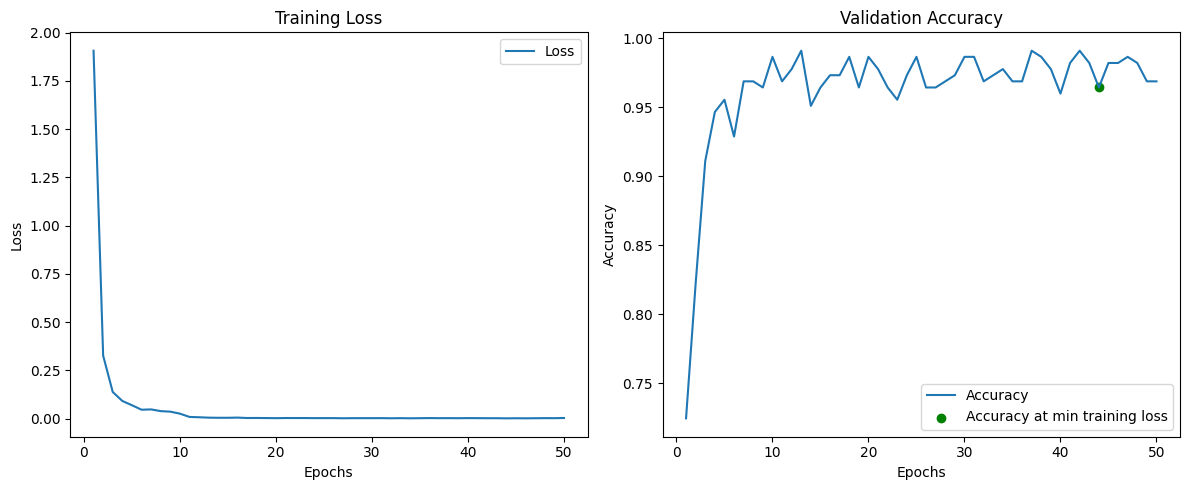

In [116]:
# Plot learning curls
import matplotlib.pyplot as plt
epochs = list(range(1, epoch_count+1))  # Number of epochs, adjust as needed


print(f"min_loss_accuracy={min_loss_accuracy}")
# Plotting Loss
plt.figure(figsize=(12, 5))


# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Accuracy')
plt.scatter(min_loss_accuracy["epoch"], min_loss_accuracy["accuracy"], color="green", label="Accuracy at min training loss")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()